In [1]:
from __future__ import annotations

# Standard libraries
import logging
import math
import random
from contextlib import contextmanager
from functools import partial
from operator import attrgetter, itemgetter
from pathlib import Path

# Third-party libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch import nn, optim, tensor

# fastai/fastcore libraries
import fastcore.all as fc
from fastcore.test import test_close

# Custom libraries (miniai, datasets)
from datasets import load_dataset
from miniai.datasets import *
from miniai.learner import *

In [2]:
# PyTorch settings and matplotlib settings
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

In [3]:
# Disable logging warnings
logging.disable(logging.WARNING)

In [4]:
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [5]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

In [6]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act:
        res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14, we're applying 8 filters to the input image, resulting in 8 feature maps, each of size 14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

In [7]:
from torcheval.metrics import MulticlassAccuracy

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [8]:
def fit(model, epochs=1, xtra_cbs=None):
    learner = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learner.fit(epochs)
    return learner

accuracy,loss,epoch,train
0.156,2.301,0,train
0.265,2.121,0,eval


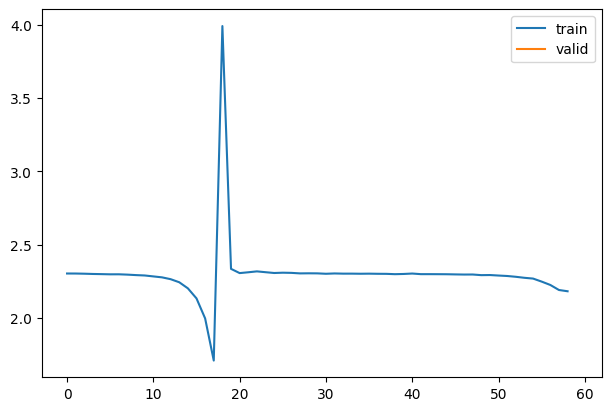

In [9]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

In [10]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds [i].append(to_cpu(x).std ())
        return x
    
    def __iter__(self):
        return iter(self.layers)

In [11]:
model = nn.Sequential(*cnn_layers())

In [12]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [13]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(to_cpu(outp).mean())
    act_stds [i].append(to_cpu(outp).std())

In [14]:
for i,layer in enumerate(model):
    layer.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
0.174,2.304,0,train
0.176,2.291,0,eval


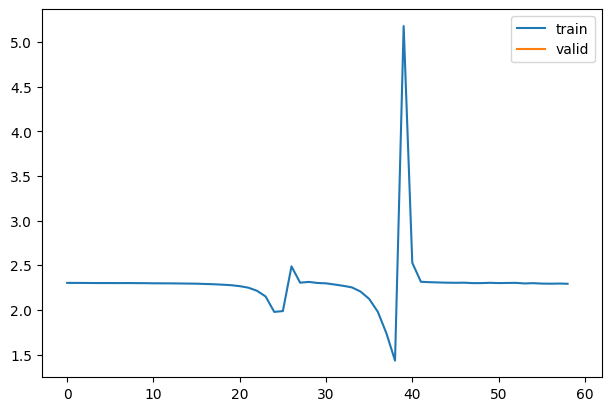

In [15]:
fit(model)

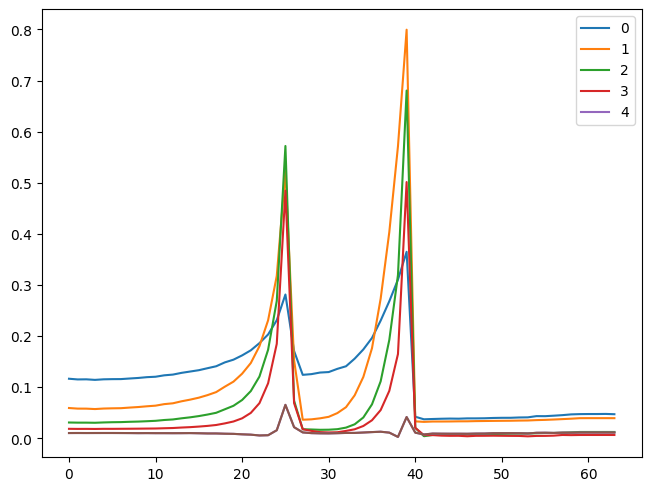

In [16]:
for o in act_means: 
    plt.plot(o)
plt.legend(range(5));

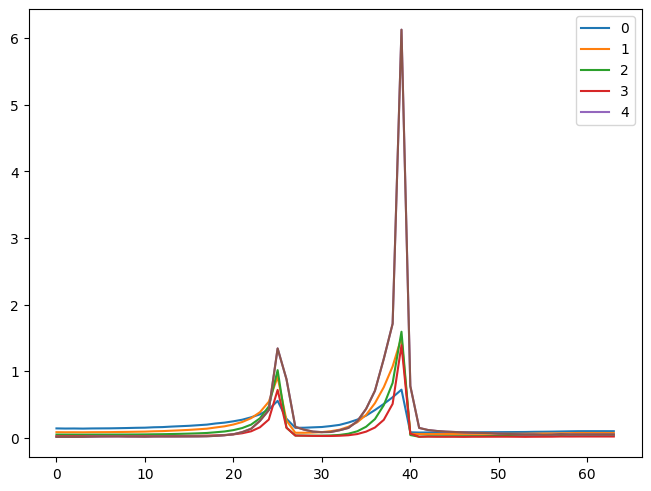

In [17]:
for o in act_stds: 
    plt.plot(o)
plt.legend(range(5));

In [18]:
class Hook():
    def __init__(self, m, f): 
        self.hook = m.register_forward_hook(partial(f, self))
    def remove(self):
        self.hook.remove()
    def __del__(self):
        self.remove()

In [19]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'):
        hook.stats = ([],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [20]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [21]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

In [22]:
class Hooks(list):
    def __init__(self, ms, f):
        super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args):
        return self
    def __exit__ (self, *args):
        self.remove()
    def __del__(self):
        self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self:
            h.remove()

In [23]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

accuracy,loss,epoch,train
0.156,2.301,0,train
0.265,2.121,0,eval


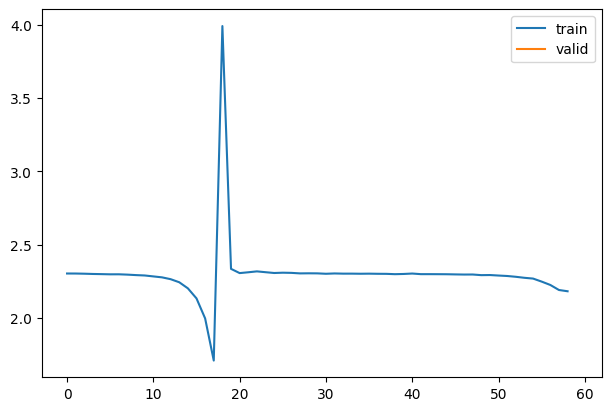

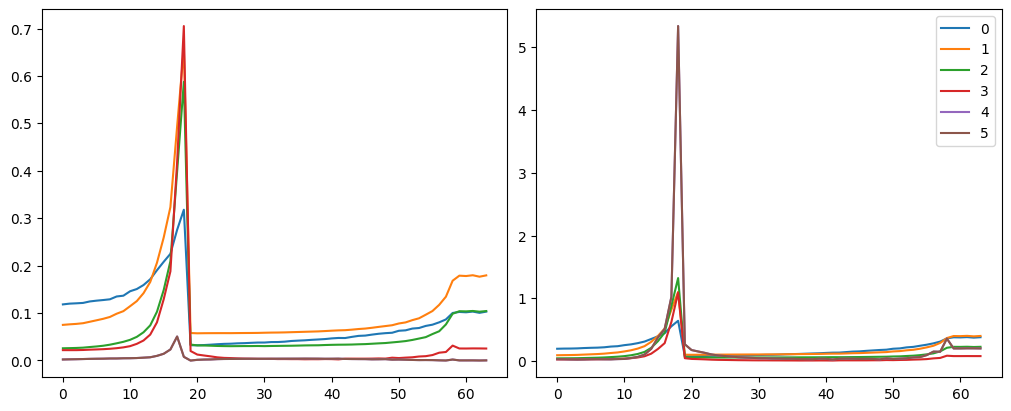

In [24]:
with Hooks(model, append_stats) as hooks:
    fit(model)
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        for i in 0,1: 
            axs[i].plot(h.stats[i])
    plt.legend(range(6));

In [25]:
for m in model:
    print(m)

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): ReLU()
)
Sequential(
  (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)
Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)
Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)
Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
Flatten(start_dim=1, end_dim=-1)


In [26]:
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()

    def before_fit(self, learn):
        if self.mods:
            mods = self.mods
        else:
            mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training):
            self.hookfunc(*args, **kwargs)

    def after_fit(self, learn):
        self.hooks.remove()
    def __iter__(self):
        return iter(self.hooks)
    def __len__(self):
        return len(self.hooks)

In [27]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.156,2.301,0,train
0.265,2.121,0,eval


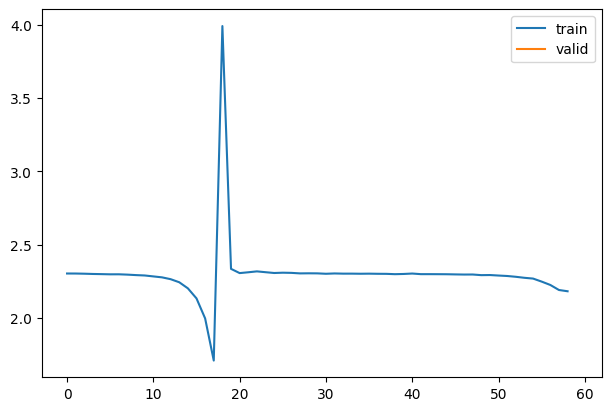

In [28]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[hc]);